In [1]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import DataLoader, get_sinusoid_example, to_float64
from prior import *
from laplax.extra.fsp import *
from plotting import plot_sinusoid_task
from laplax.extra.fsp.fsp import compute_matrix_jacobian_product
import laplax
from laplax.extra.fsp import lanczos_isqrt
from laplax import util
from laplax.util.tree import to_dtype
from functools import partial
from pathlib import Path
from laplax.curv.cov import Posterior
from laplax.curv.cov import PosteriorState
from plotting import plot_regression_with_uncertainty
from laplax.eval.pushforward import set_lin_pushforward
from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_pred_var,
    lin_samples,
    lin_setup,
    set_lin_pushforward,
)
jax.config.update("jax_enable_x64", True)

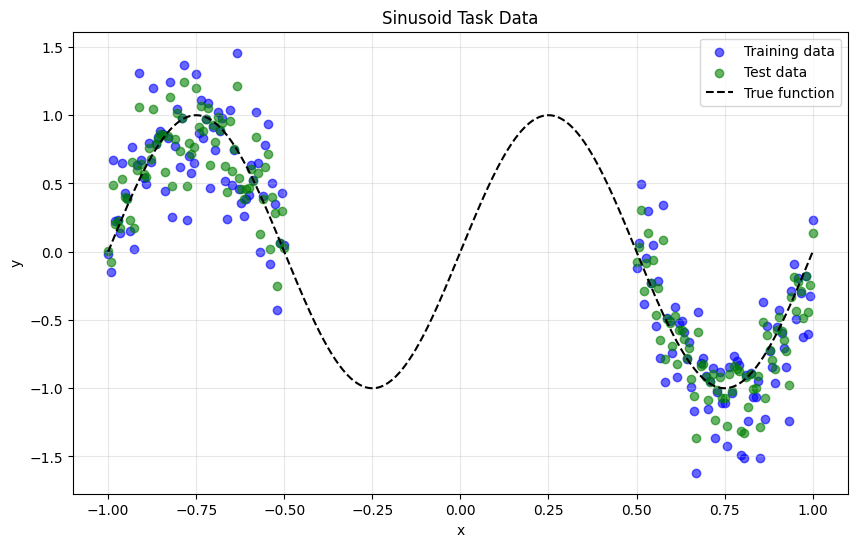

In [2]:
batch_size = 10
key = jax.random.key(0)
X_train1 = jnp.linspace(-1, -0.5, 75).reshape(-1, 1)
X_train2 = jnp.linspace(0.5, 1, 75).reshape(-1, 1)
X_train = jnp.concatenate([X_train1, X_train2], axis=0)
y_train = jnp.reshape(jnp.sin(X_train * 6.24) + jax.random.normal(key, (150, 1)) * 0.3, (-1, 1))
X_test = X_train
y_test = jnp.reshape(jnp.sin(X_train * 6.24) + jax.random.normal(key, (150, 1)) * 0.2, (-1, 1))
train_loader = DataLoader(X_train, y_train, batch_size)
data = {"input": X_train, "target": y_train}

fig = plot_sinusoid_task(X_train, y_train, X_test, y_test)
key = jax.random.PRNGKey(113756440)


In [3]:
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_channels, hidden_channels, rngs=rngs)
        self.linear3 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear3(
            nnx.tanh(self.linear2(
                nnx.tanh(self.linear1(x)))
                )
            )
        return x
    
model = Model(in_channels=1, hidden_channels=50, out_channels=1, rngs=nnx.Rngs(2))
model = to_float64(model)
graph_def, params = nnx.split(model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]

prior_params = {
    "per_ls": 280, "per_p": 1.0, "per_var": 1.0,
    "m52_ls": 1.0, "m52_var": 1.0,
    "m12_ls": 0.25, "m12_var": 0.0002,
} 

gram(jnp.linspace(-1, 1, 100).reshape(-1, 1), prior_params, composite_kernel)
K = gram(jnp.linspace(-3, 3, 15).reshape(-1,1), prior_params, composite_kernel, jitter=1e-16)
assert jnp.linalg.eigvalsh(K).all() > 0, "Gram matrix is not positive definite"
kernel_fn = lambda xc: gram(xc, prior_params, composite_kernel)


In [4]:
@nnx.jit(static_argnames=['loss_fn']) 
def train_step(model, data, x_context, scale, loss_fn):
    def loss_function(model):
        _, current_params = nnx.split(model)
        return loss_fn(data, x_context, current_params, scale)
    
    loss, grads = nnx.value_and_grad(loss_function)(model)
    return loss, grads


def train_model(model, n_epochs, lr=1e-3):
   
    optimizer = nnx.Optimizer(model, optax.adam(lr))
    graph_def, params = nnx.split(model)
    
    def model_fn(input, params):
        return nnx.call((graph_def, params))(input)[0]
    
    loss_fn = create_fsp_objective(model_fn, 150, jnp.zeros((150, 1)), kernel_fn)

    # Train epoch
    nnx.jit
    for epoch in range(n_epochs):
        for x_tr, y_tr in train_loader:
            data = {"input": x_tr, "target": y_tr}
            x_context = jnp.linspace(-1, 1, 150).reshape(-1, 1)

            loss, grads = train_step(model, data, x_context, 0.1, loss_fn)
            optimizer.update(grads)

        if epoch % 100 == 0:
            print(f"[epoch {epoch}]: loss: {loss:.4f}")

    print(f"Final loss: {loss:.4f}")
    return model


model = train_model(model, n_epochs=1000)

[epoch 0]: loss: 1969669.4572
[epoch 100]: loss: 3518.8795
[epoch 200]: loss: 2123.1231
[epoch 300]: loss: 5922.4364
[epoch 400]: loss: 6690.9288
[epoch 500]: loss: 1454.2369
[epoch 600]: loss: 7542.0875
[epoch 700]: loss: 2122.2798
[epoch 800]: loss: 3692.9570
[epoch 900]: loss: 7074.0751
Final loss: 6686.5735


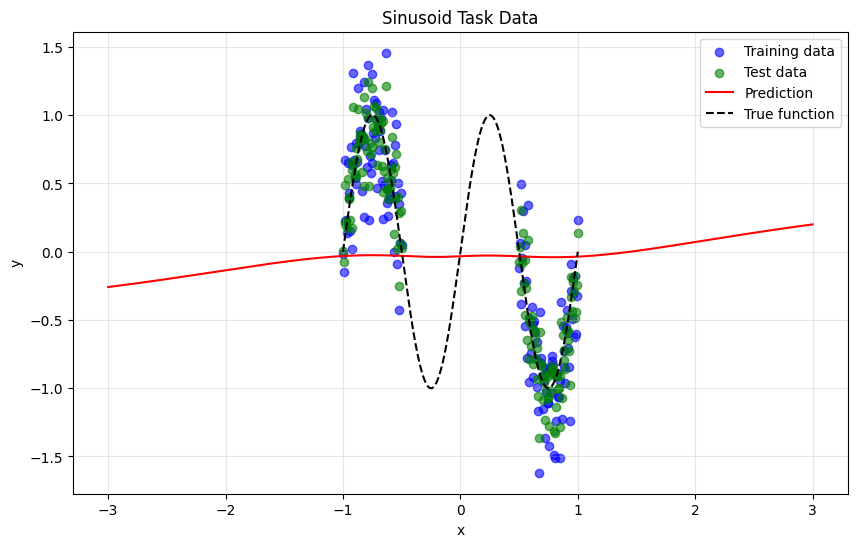

In [5]:
X_pred = jnp.linspace(-3., 3., 200).reshape(200, 1)
y_pred = jax.vmap(model)(X_pred)

_ = plot_sinusoid_task(X_train, y_train, X_test, y_test, X_pred, y_pred)

In [6]:
data = {
    "input": X_train,
    "target": y_train,
}

graph_def, params = nnx.split(model)

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


v = lanczos_jacobian_initialization(model_fn, params, data)

context_points = select_context_points(150, "grid",
        [2.0],
        [-2.0],
        X_train.shape,
        key=jax.random.key(0),
    )
cov_matrix = kernel_fn(context_points)
prior_var = jnp.diag(cov_matrix)

cov_matrix = kernel_fn(context_points)
prior_var = jnp.diag(cov_matrix)
L = lanczos_invert_sqrt(cov_matrix, v, tol=jnp.finfo(v.dtype).eps)

eta: 56.011779844655 - sq_norm = 1.0
eta: 5.817707093243745e-05 - sq_norm = 1.677973571445583
eta: 0.0030788677315489146 - sq_norm = 41.90358317545625
eta: 8.603383248550303e-07 - sq_norm = 0.0008925749003422323
eta: 1.7383219100414592e-14 - sq_norm = 1.733052959302288e-08
eta: 3.225054521103247e-27 - sq_norm = 3.2177901508707074e-21


In [7]:
M, unravel_fn = compute_matrix_jacobian_product(model_fn, params, data, L, has_batch_dim=False)
_u, _s, _ = jnp.linalg.svd(M, full_matrices=False)
tol = jnp.finfo(M.dtype).eps ** 2
s = _s[_s > tol]
u = _u[:, : s.size]
ggn_matrix = create_fsp_ggn_mv(model_fn, params, M)(data)

In [8]:
cov_sqrt = compute_curvature_fn(
    model_fn,
    params,
    data,
    ggn_matrix,
    prior_var,
    u
)

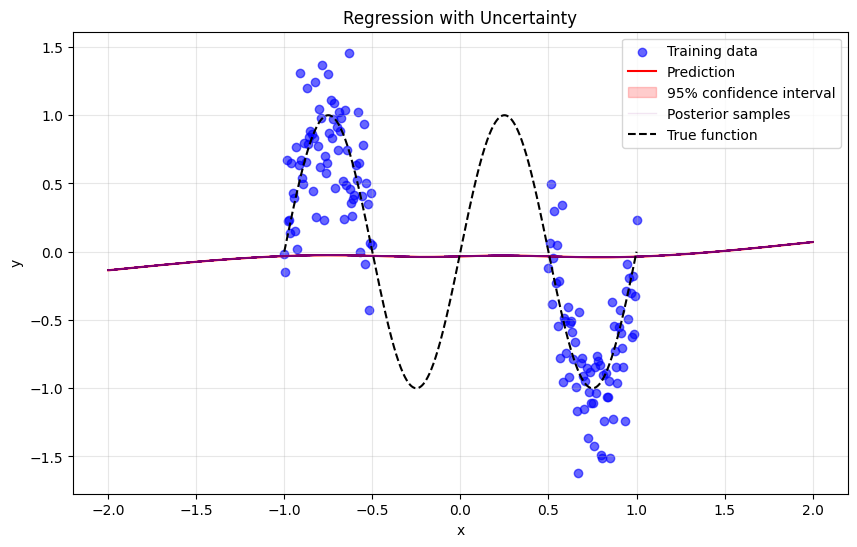

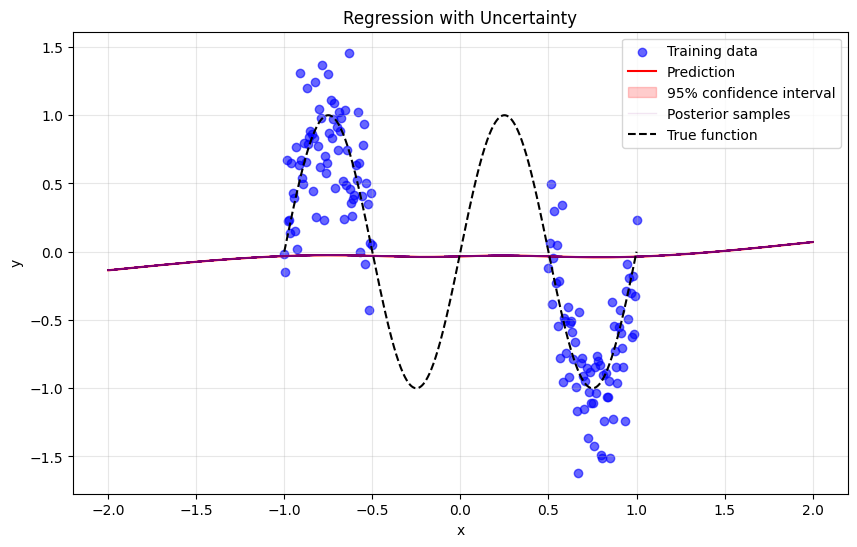

In [9]:
posterior_state: PosteriorState = {"scale_sqrt": cov_sqrt}
flatten, unflatten = laplax.util.flatten.create_pytree_flattener(params)
posterior = Posterior(
    state=posterior_state,
    cov_mv=lambda state: lambda x: unflatten(
        state["scale_sqrt"] @ state["scale_sqrt"].T @ flatten(x)
    ),
    scale_mv=lambda state: lambda x: unflatten(state["scale_sqrt"] @ x),
    rank=cov_sqrt.shape[1],
)

posterior_fn = lambda *args, **kwargs: posterior  # noqa: E731

set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_var,
        lin_pred_std,
        lin_samples,
    ],
    key=jax.random.key(6548),
    num_samples=100,
)

prob_predictive = set_prob_predictive(
    prior_arguments={},
)
X_pred = jnp.linspace(-2, 2, 200, dtype=jnp.float64).reshape(-1, 1)

pred = jax.vmap(prob_predictive)(X_pred)

X_pred = jnp.linspace(-2, 2, 200, dtype=jnp.float64).reshape(-1, 1)

pred = jax.vmap(prob_predictive)(X_pred)
plot_regression_with_uncertainty(
        X_train=data["input"],
        y_train=data["target"],
        X_pred=X_pred,
        y_pred=pred["pred_mean"][:, 0],
        y_std=jnp.sqrt(pred["pred_var"][:, 0]),
        y_samples=pred["samples"],
    )